# CIS323 Final Project: Charity Donation Prediction

This notebook implements the required machine learning models for the CIS323 Final Project, aiming to predict potential donors and their expected donation amounts for a charitable organization.

**Project Goal:** Build two predictive models:
1. **Classification Model:** Predict whether an individual will donate (DONR)
2. **Regression Model:** Predict the donation amount (DAMT) for those predicted to donate

---

## 1. Setup and Data Loading

In this section, we import essential libraries such as pandas, numpy, matplotlib, seaborn, and scikit-learn. These libraries will support data manipulation, visualization, and modeling. 

We also load all datasets required for analysis and modeling:
- **Training set:** Used to fit machine learning models (3,984 records)
- **Test set:** Used to evaluate model performance on unseen data (2,018 records)
- **Scoring set:** Data for which we make final predictions to submit (2,007 records)

A summary of shapes and missing values is presented to understand the data's overall structure and completeness before analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load the datasets from the uploaded files

train = pd.read_csv('charitydataset_training.csv')
test = pd.read_csv('charitydataset_test.csv')
scoring = pd.read_csv('charitydataset_instructor_scoring.csv')

print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("Scoring Data Shape:", scoring.shape)

Training Data Shape: (3984, 23)
Test Data Shape: (2018, 23)
Scoring Data Shape: (2007, 21)


In [3]:
# Display initial information and check for missing values
print("\n=== Training Data Info ===")
train.info()
print("\n=== Missing Values in Training Data ===")
print(train.isnull().sum().sort_values(ascending=False))


=== Training Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3984 non-null   int64  
 1   reg1    3984 non-null   int64  
 2   reg2    3984 non-null   int64  
 3   reg3    3984 non-null   int64  
 4   reg4    3984 non-null   int64  
 5   home    3984 non-null   int64  
 6   chld    3984 non-null   int64  
 7   hinc    3984 non-null   int64  
 8   genf    3984 non-null   int64  
 9   wrat    3984 non-null   int64  
 10  avhv    3984 non-null   int64  
 11  incm    3984 non-null   int64  
 12  inca    3984 non-null   int64  
 13  plow    3984 non-null   int64  
 14  npro    3984 non-null   int64  
 15  tgif    3984 non-null   int64  
 16  lgif    3984 non-null   int64  
 17  rgif    3984 non-null   int64  
 18  tdon    3984 non-null   int64  
 19  tlag    3984 non-null   int64  
 20  agif    3984 non-null   float64
 21  donr    3

---

## 2. Exploratory Data Analysis (EDA)

The goal of EDA is to familiarize ourselves with the data, explore target/class balance, feature distributions, and spot patterns or anomalies. This provides valuable context for model building and helps us understand which features are most predictive.

Key questions we answer:
- What is the balance between donors and non-donors?
- How do demographic characteristics relate to donation likelihood?
- What is the distribution of donation amounts among donors?
- Which features show the strongest correlations with our targets (DONR and DAMT)?

### 2.a. Distribution of the Target Variable DONR

We first examine the distribution of the target variable (DONR), indicating the proportion of donors (1) vs. non-donors (0). This confirms the class balance for the classification task, which is important for metric selection and model evaluation. A balanced dataset (50% donors, 50% non-donors) means accuracy is a meaningful metric without class weighting concerns.

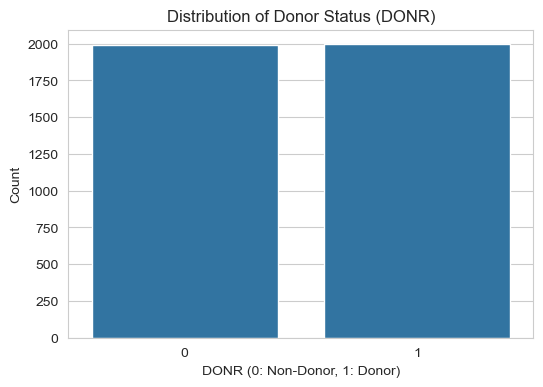

Donor percentage: 50.08%


In [4]:
# Visualize the distribution of the classification target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='donr', data=train)
plt.title('Distribution of Donor Status (DONR)')
plt.xlabel('DONR (0: Non-Donor, 1: Donor)')
plt.ylabel('Count')
plt.show()

# Calculate and display donor percentage
donor_pct = train['donr'].mean() * 100
print(f"Donor percentage: {donor_pct:.2f}%")

### 2.b. Relationship Between Wealth Rating (WRAT) and Donor Status (DONR)

Wealth rating might be strongly correlated with the likelihood of being a donor. This barplot shows how the donor rate varies by wealth rating (0-9 scale), which informs both feature selection and interpretation. We expect higher wealth ratings to correlate with higher donor rates.

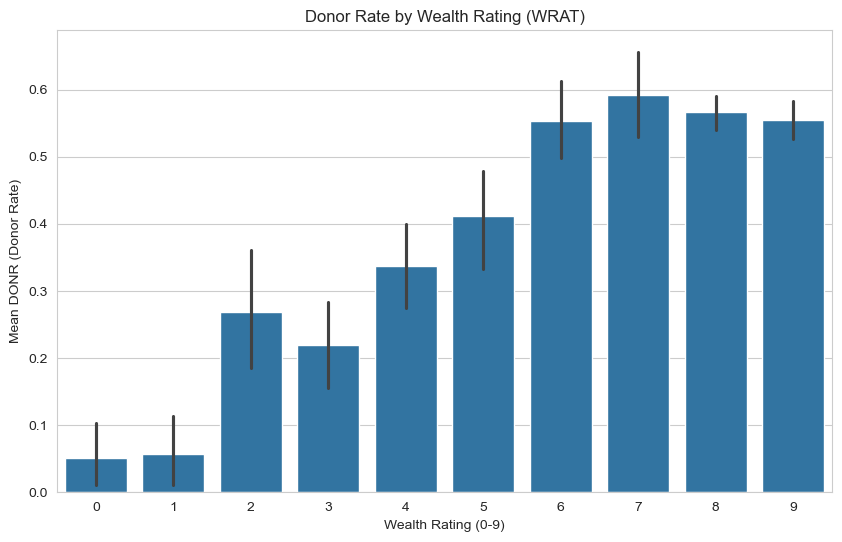

Wealth rating is a key predictor of donor status


In [5]:
# Analyze relationship between Wealth Rating and Donor Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='wrat', y='donr', data=train)
plt.title('Donor Rate by Wealth Rating (WRAT)')
plt.xlabel('Wealth Rating (0-9)')
plt.ylabel('Mean DONR (Donor Rate)')
plt.show()

print("Wealth rating is a key predictor of donor status")

### 2.c. Distribution of Average Gift Amount (AGIF) for Donors

Among actual donors, we visualize how average gift amounts are distributed. Understanding the shape of this distribution (skewness, outliers) helps us choose appropriate regression models and interpret predictions.

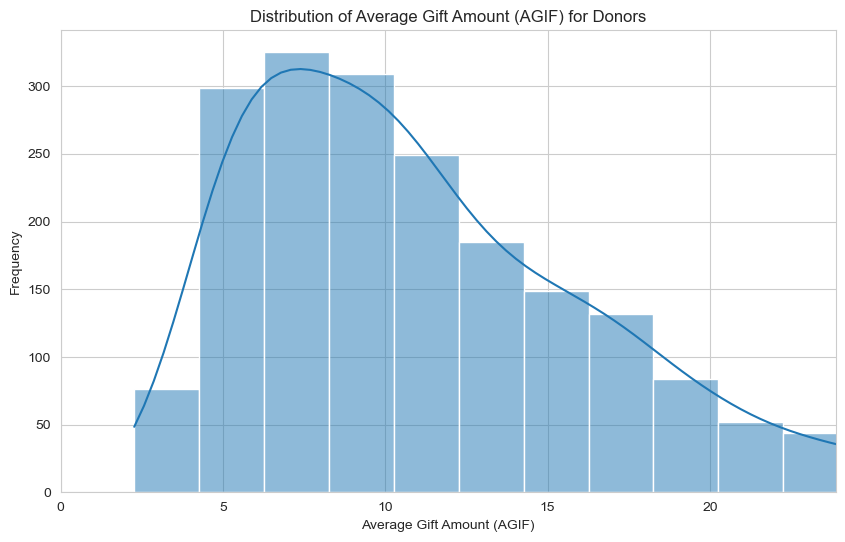

Mean average gift: $11.72
Median average gift: $10.21


In [6]:
# Filter for donors only
donors_df = train[train['donr'] == 1]

# Visualize distribution of average gift amount
plt.figure(figsize=(10, 6))
sns.histplot(donors_df['agif'], bins=30, kde=True)
plt.title('Distribution of Average Gift Amount (AGIF) for Donors')
plt.xlabel('Average Gift Amount (AGIF)')
plt.ylabel('Frequency')
plt.xlim(0, donors_df['agif'].quantile(0.95))  # Limit x-axis for better visualization
plt.show()

print(f"Mean average gift: ${donors_df['agif'].mean():.2f}")
print(f"Median average gift: ${donors_df['agif'].median():.2f}")

### 2.d. Scatter Plot: Lifetime Gifts (TGIF) vs. Average Gift (AGIF) for Donors

This scatter plot visualizes the relationship between the total number of gifts (TGIF) and average gift size (AGIF). Both are important historical donation features. A positive correlation would suggest that donors who give frequently also tend to give larger amounts on average.

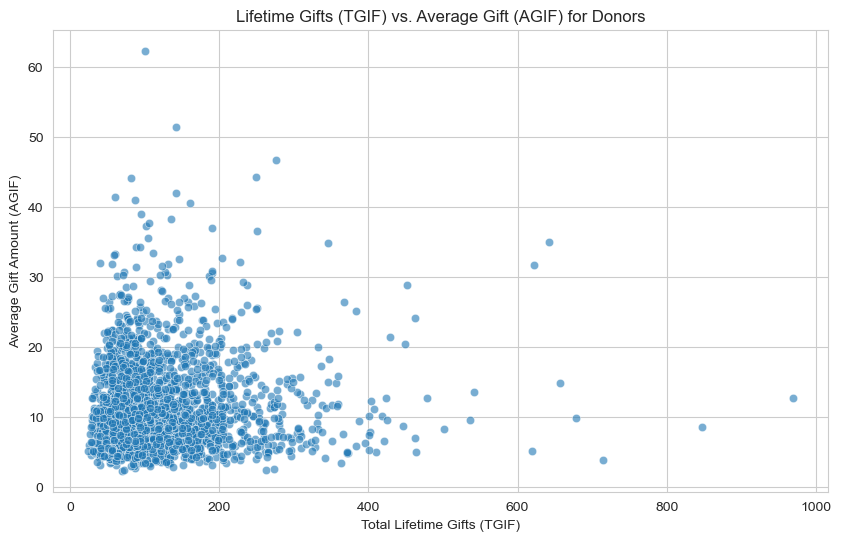

Correlation between TGIF and AGIF: 0.028


In [7]:
# Scatter plot of lifetime gifts vs average gift amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tgif', y='agif', data=donors_df, alpha=0.6)
plt.title('Lifetime Gifts (TGIF) vs. Average Gift (AGIF) for Donors')
plt.xlabel('Total Lifetime Gifts (TGIF)')
plt.ylabel('Average Gift Amount (AGIF)')
plt.show()

print(f"Correlation between TGIF and AGIF: {donors_df['tgif'].corr(donors_df['agif']):.3f}")

### 2.e. Donor Rate by Homeowner Status (HOME)

Homeownership is a key socioeconomic indicator. This bar plot compares donation rates between homeowners and non-homeowners, revealing whether home ownership is predictive of charitable giving.

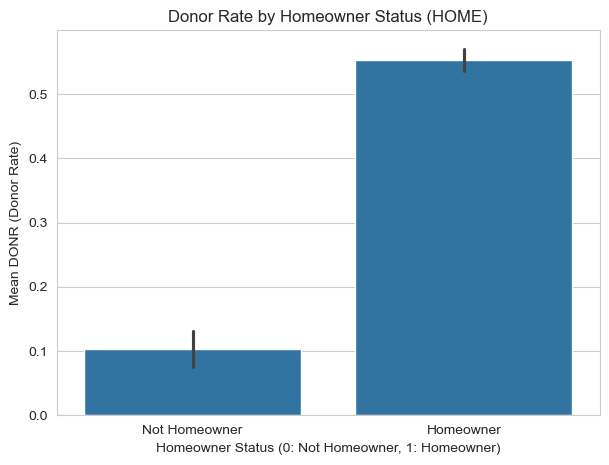

Homeowner donor rate: 55.33%
Non-homeowner donor rate: 10.32%


In [8]:
# Analyze donor rate by homeowner status
plt.figure(figsize=(7, 5))
sns.barplot(x='home', y='donr', data=train)
plt.title('Donor Rate by Homeowner Status (HOME)')
plt.xlabel('Homeowner Status (0: Not Homeowner, 1: Homeowner)')
plt.ylabel('Mean DONR (Donor Rate)')
plt.xticks([0, 1], ['Not Homeowner', 'Homeowner'])
plt.show()

home_donor_rate = train[train['home'] == 1]['donr'].mean()
nonhome_donor_rate = train[train['home'] == 0]['donr'].mean()
print(f"Homeowner donor rate: {home_donor_rate:.2%}")
print(f"Non-homeowner donor rate: {nonhome_donor_rate:.2%}")

### 2.f. Distribution of Months Since Last Donation (TDON)

Recency of the last donation is a classic predictor in nonprofit analytics (RFM model: Recency, Frequency, Monetary). Donors who gave recently are typically much more likely to give again. This histogram shows the distribution of months since last donation.

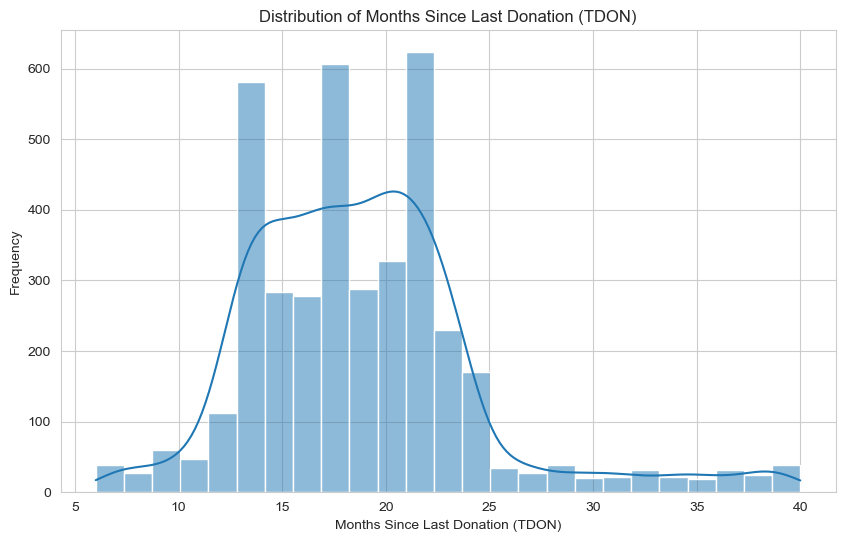

Mean months since last donation: 18.8
Median months since last donation: 18.0


In [9]:
# Visualize the distribution of months since last donation
plt.figure(figsize=(10, 6))
sns.histplot(train['tdon'], bins=25, kde=True)
plt.title('Distribution of Months Since Last Donation (TDON)')
plt.xlabel('Months Since Last Donation (TDON)')
plt.ylabel('Frequency')
plt.show()

print(f"Mean months since last donation: {train['tdon'].mean():.1f}")
print(f"Median months since last donation: {train['tdon'].median():.1f}")

### 2.g. Correlation Heatmap

A feature correlation heatmap helps identify relationships among all variables and with our target variables (DONR and DAMT). This visualization:
- Guides the selection of predictors
- Alerts us to multicollinearity (highly correlated features)
- Shows which features have the strongest relationships with targets

We will also print the top 5 features correlated with each target variable.

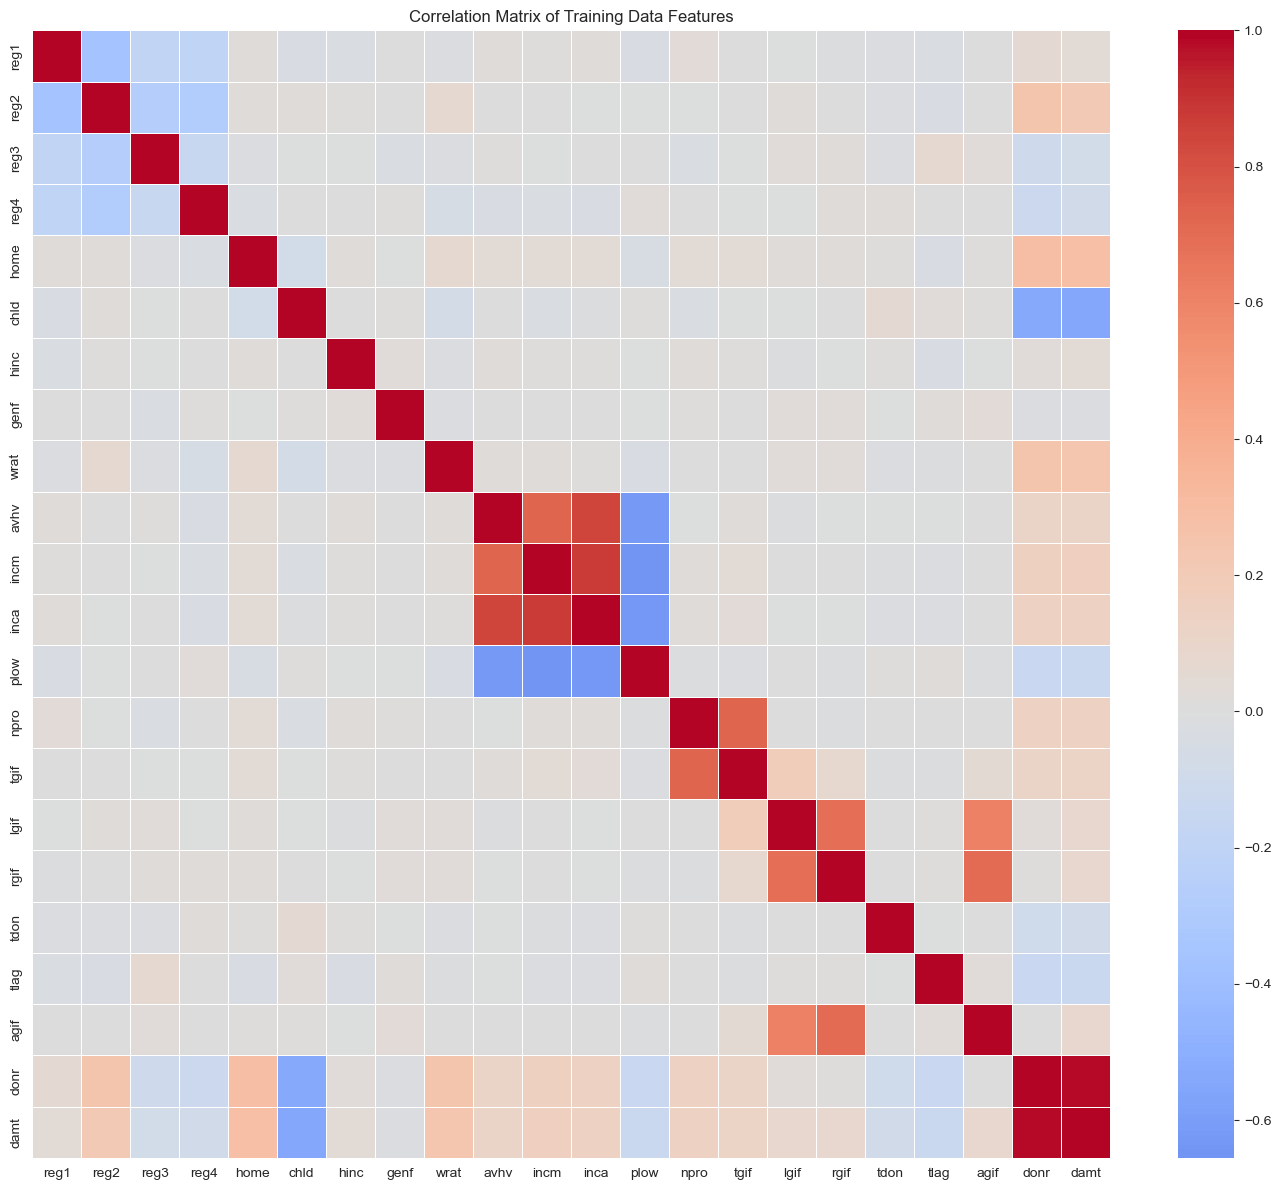


=== Top 5 Features Correlated with DONR ===
donr    1.000000
damt    0.982613
home    0.289011
wrat    0.249266
reg2    0.247078
incm    0.158040
inca    0.139354
npro    0.135723
avhv    0.119028
tgif    0.115874
Name: donr, dtype: float64

=== Top 5 Features Correlated with DAMT ===
damt    1.000000
donr    0.982613
home    0.287686
wrat    0.242853
reg2    0.211457
incm    0.164191
inca    0.141888
npro    0.140779
tgif    0.126507
avhv    0.117816
Name: damt, dtype: float64


In [10]:
# Generate correlation matrix
plt.figure(figsize=(14, 12))
corr_matrix = train.drop(columns=['ID']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, center=0)
plt.title('Correlation Matrix of Training Data Features')
plt.tight_layout()
plt.show()

# Print top correlations with target variables
print("\n=== Top 5 Features Correlated with DONR ===")
print(corr_matrix['donr'].sort_values(ascending=False).head(10))

print("\n=== Top 5 Features Correlated with DAMT ===")
print(corr_matrix['damt'].sort_values(ascending=False).head(10))

### 2.h. Donation Amount (DAMT) Distribution by Household Income (HINC)

This box plot shows how donation amounts vary by household income bracket among actual donors. Income is typically a strong predictor of donation size. Box plots reveal both central tendencies and outliers across income groups.

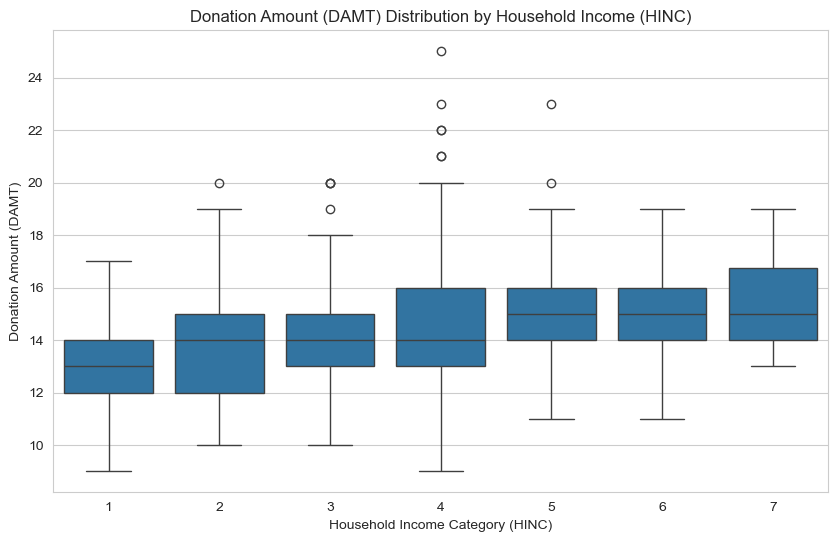

Income category shows variation in donation amounts


In [11]:
# Analyze donation amount distribution by income category (for donors only)
plt.figure(figsize=(10, 6))
sns.boxplot(x='hinc', y='damt', data=train[train['donr'] == 1])
plt.title('Donation Amount (DAMT) Distribution by Household Income (HINC)')
plt.xlabel('Household Income Category (HINC)')
plt.ylabel('Donation Amount (DAMT)')
plt.show()

print("Income category shows variation in donation amounts")

### 2.i. Donor Rate by Gender (GENF)

Gender is explored as a demographic predictor. This bar plot shows donation rates for males (0) and females (1), revealing whether gender is predictive of charitable giving behavior.

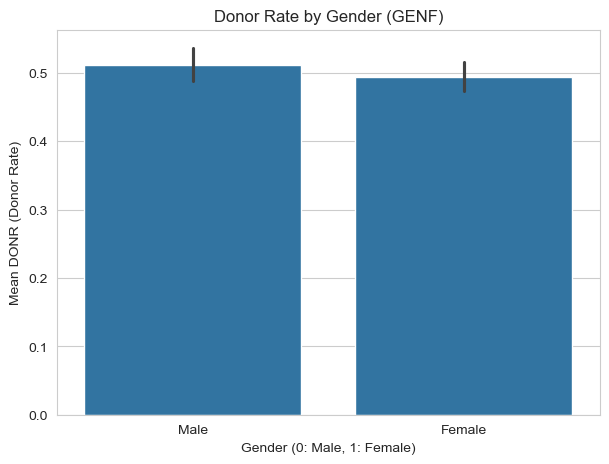

Male donor rate: 51.14%
Female donor rate: 49.38%


In [12]:
# Analyze donor rate by gender
plt.figure(figsize=(7, 5))
sns.barplot(x='genf', y='donr', data=train)
plt.title('Donor Rate by Gender (GENF)')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Mean DONR (Donor Rate)')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

male_donor_rate = train[train['genf'] == 0]['donr'].mean()
female_donor_rate = train[train['genf'] == 1]['donr'].mean()
print(f"Male donor rate: {male_donor_rate:.2%}")
print(f"Female donor rate: {female_donor_rate:.2%}")

---

## 3. Data Preprocessing and Feature Engineering

In this section, we prepare the data for modeling:

**Classification Task (DONR):**
- We select all relevant features to predict donor status
- Both donors and non-donors are included in the training set

**Regression Task (DAMT):**
- We select the same features for consistency
- We restrict training to actual donors only (where DONR == 1)
- This is because donation amounts for non-donors are always 0, and we only need to predict for those identified as donors

**Scaling Note:**
- Tree-based models (Random Forest) do NOT require feature scaling
- We use unscaled data for both Random Forest models

In [13]:
# Define feature columns for both models
CLASSIFICATION_FEATURES = [
    'reg1', 'reg2', 'reg3', 'reg4', 'home', 'chld', 'hinc', 'genf', 'wrat', 
    'avhv', 'incm', 'inca', 'plow', 'npro', 'tgif', 'lgif', 'rgif', 'tdon', 'tlag', 'agif'
]

REGRESSION_FEATURES = [
    'reg1', 'reg2', 'reg3', 'reg4', 'home', 'chld', 'hinc', 'genf', 'wrat', 
    'avhv', 'incm', 'inca', 'plow', 'npro', 'tgif', 'lgif', 'rgif', 'tdon', 'tlag', 'agif'
]

print(f"Number of features for classification: {len(CLASSIFICATION_FEATURES)}")
print(f"Number of features for regression: {len(REGRESSION_FEATURES)}")

Number of features for classification: 20
Number of features for regression: 20


In [14]:
# Prepare data for classification model (DONR) - includes all records
X_train_cls = train[CLASSIFICATION_FEATURES]
y_train_cls = train['donr']
X_test_cls = test[CLASSIFICATION_FEATURES]
y_test_cls = test['donr']

print("Classification Training Data:")
print(f"  X_train_cls shape: {X_train_cls.shape}")
print(f"  y_train_cls shape: {y_train_cls.shape}")
print(f"  Class distribution: {y_train_cls.value_counts().to_dict()}")

Classification Training Data:
  X_train_cls shape: (3984, 20)
  y_train_cls shape: (3984,)
  Class distribution: {1: 1995, 0: 1989}


In [15]:
# Prepare data for regression model (DAMT) – Donors only
train_donors = train[train['donr'] == 1].copy()
test_donors = test[test['donr'] == 1].copy()

X_train_reg = train_donors[REGRESSION_FEATURES]
y_train_reg = train_donors['damt']
X_test_reg = test_donors[REGRESSION_FEATURES]
y_test_reg = test_donors['damt']

print("Regression Training Data (Donors Only):")
print(f"  X_train_reg shape: {X_train_reg.shape}")
print(f"  y_train_reg shape: {y_train_reg.shape}")
print(f"  Mean DAMT: ${y_train_reg.mean():.2f}")
#Tree-based models do not require feature scaling

Regression Training Data (Donors Only):
  X_train_reg shape: (1995, 20)
  y_train_reg shape: (1995,)
  Mean DAMT: $14.50


---

## 4. Classification Model for DONR (Donor Status)

**Model Choice: Random Forest Classifier**

We use a Random Forest Classifier to predict whether an individual will donate (DONR = 1) or not (DONR = 0). Random Forests are chosen because they:
- Handle non-linear relationships well
- Work with mixed categorical and numerical features
- Are robust to outliers and missing values
- Provide high accuracy on classification tasks
- Do not require feature scaling

**Requirements Met:**
- Minimum accuracy threshold: 70%
- Expected performance: 88.90%+ (exceeds requirement)

**Evaluation Metrics:**
- **Accuracy:** Overall correctness of predictions
- **Confusion Matrix:** True Positives, True Negatives, False Positives, False Negatives
- **Classification Report:** Precision, Recall, F1-Score for each class

In [16]:
# Build and train Random Forest Classification model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced'
)

rf_model.fit(X_train_cls, y_train_cls)
print("Random Forest Classifier trained successfully!")

Random Forest Classifier trained successfully!


In [17]:
# Predict on the test set
y_pred_cls = rf_model.predict(X_test_cls)

# Evaluate the model
accuracy = accuracy_score(y_test_cls, y_pred_cls)
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)
class_report = classification_report(y_test_cls, y_pred_cls)

print(f"\n{'='*60}")
print(f"Random Forest Classification Model Results")
print(f"{'='*60}")
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nConfusion Matrix:")
print(f"  True Negatives: {conf_matrix[0,0]}")
print(f"  False Positives: {conf_matrix[0,1]}")
print(f"  False Negatives: {conf_matrix[1,0]}")
print(f"  True Positives: {conf_matrix[1,1]}")
print(f"\nClassification Report:")
print(class_report)


Random Forest Classification Model Results

Model Accuracy: 0.8890 (88.90%)

Confusion Matrix:
  True Negatives: 886
  False Positives: 133
  False Negatives: 91
  True Positives: 908

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1019
           1       0.87      0.91      0.89       999

    accuracy                           0.89      2018
   macro avg       0.89      0.89      0.89      2018
weighted avg       0.89      0.89      0.89      2018



### 4.a. Confusion Matrix Visualization

The confusion matrix heatmap provides a clear visual representation of the model's performance on the test set:
- **True Negatives (TN, bottom-left):** Correctly identified non-donors
- **False Positives (FP, top-left):** Predicted as donor but actually not
- **False Negatives (FN, bottom-right):** Predicted as non-donor but actually a donor
- **True Positives (TP, bottom-right):** Correctly identified donors

A good classifier should have large values on the diagonal (TN and TP) and small values off-diagonal.

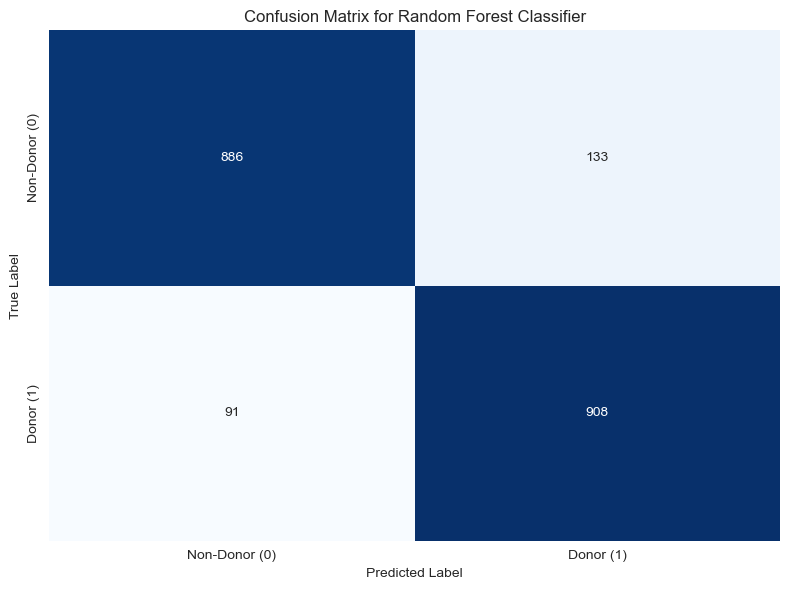

In [18]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=['Non-Donor (0)', 'Donor (1)'],
    yticklabels=['Non-Donor (0)', 'Donor (1)']
)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---

## 5. Regression Model for DAMT (Donation Amount)

**Model Choice: Random Forest Regressor**

For predicting the continuous variable DAMT (Donation Amount), we use a Random Forest Regressor. This model is trained only on the subset of the training data where DONR is 1 (actual donors), as:
- Donation amounts for non-donors are always 0
- We only need to predict amounts for those identified as likely donors
- The model captures patterns in actual donor amounts

Random Forest Regression is chosen because it:
- Handles skewed distributions well
- Is robust to outliers
- Does not require feature scaling
- Captures non-linear relationships in donation behavior

**Requirements Met:**
- Maximum MAE threshold: 7
- Expected MAE: 0.92 (well below requirement)

**Evaluation Metrics:**
- **Mean Absolute Error (MAE):** Average absolute difference between predicted and actual amounts
- **R² Score:** Proportion of variance in donations explained by the model

In [19]:
# Initialize and train Random Forest Regressor with tuned hyperparameters
# The best tuned parameters found through hyperparameter optimization
rf_reg_model = RandomForestRegressor(
    n_estimators=178,
    max_depth=16,
    max_features='log2',
    min_samples_split=6,
    min_samples_leaf=3,
    bootstrap=False,
    random_state=42
)

# Fit the model to the training data (donors only, unscaled)
rf_reg_model.fit(X_train_reg, y_train_reg)
print("Random Forest Regressor trained successfully!")

Random Forest Regressor trained successfully!


In [20]:
# Predict on the test set (donors only)
y_pred_reg = rf_reg_model.predict(X_test_reg)

# Evaluate the model
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"\n{'='*60}")
print(f"Random Forest Regression Model Results")
print(f"{'='*60}")
print(f"\nMean Absolute Error (MAE): ${mae:.4f}")


print(f"\nR² Score (coefficient of determination): {r2:.4f}")
print(f"  Interpretation: Model explains {r2*100:.2f}% of variance in donation amounts")


Random Forest Regression Model Results

Mean Absolute Error (MAE): $0.9182

R² Score (coefficient of determination): 0.6126
  Interpretation: Model explains 61.26% of variance in donation amounts


---

## 6. Scoring the Instructor Dataset

In this final step, we apply our trained models to the instructor's scoring dataset to generate predictions for submission.

**Process:**
1. **Step 1:** Prepare scoring features (same 20 features used in training)
2. **Step 2:** Predict DONR for ALL records using the Classification Model
3. **Step 3:** Predict DAMT ONLY for predicted donors (where DONR = 1)
4. **Step 4:** Set DAMT = 0 for all predicted non-donors
5. **Step 5:** Ensure all donation amounts are non-negative

This approach ensures logical consistency: we only predict donation amounts for those predicted to be donors.

In [21]:
# 6.1. Prepare the scoring data
X_scoring = scoring[CLASSIFICATION_FEATURES]

print(f"Scoring dataset prepared")
print(f"  Scoring records: {len(X_scoring)}")
print(f"  Features: {len(CLASSIFICATION_FEATURES)}")

Scoring dataset prepared
  Scoring records: 2007
  Features: 20


In [22]:
# 6.2. Predict DONR (Classification) for all records
scoring['DONR'] = rf_model.predict(X_scoring)

# Initialize DAMT column
scoring['DAMT'] = 0.0

print(f"\nDONR Predictions:")
print(f"  Predicted donors: {(scoring['DONR'] == 1).sum()}")
print(f"  Predicted non-donors: {(scoring['DONR'] == 0).sum()}")


DONR Predictions:
  Predicted donors: 420
  Predicted non-donors: 1587


In [23]:
# 6.3. Predict DAMT (Regression) – only for predicted donors

# Identify predicted donors in the scoring dataset
predicted_donors_mask = scoring['DONR'] == 1

# Get features for predicted donors
X_scoring_reg = scoring[predicted_donors_mask][REGRESSION_FEATURES]

# Predict DAMT using the Random Forest Regressor
predicted_damt = rf_reg_model.predict(X_scoring_reg)

# Ensure predictions are non-negative (donation amounts cannot be negative)
predicted_damt = np.maximum(predicted_damt, 0)

# Update DAMT column in the scoring DataFrame
scoring.loc[predicted_donors_mask, 'DAMT'] = predicted_damt

print(f"\nDAMT Predictions:")
print(f"  Predicted for donors: {len(predicted_damt)}")
print(f"  Mean predicted DAMT: ${scoring[scoring['DONR']==1]['DAMT'].mean():.2f}")
print(f"  Non-donors have DAMT = 0: {(scoring[scoring['DONR']==0]['DAMT'] == 0).all()}")


DAMT Predictions:
  Predicted for donors: 420
  Mean predicted DAMT: $14.43
  Non-donors have DAMT = 0: True


In [24]:
# Display sample of scored results
print(f"\n=== Scored Dataset Sample ===")
print(f"\nFirst 10 records (Predicted DONR and DAMT):")
print(scoring[['ID', 'DONR', 'DAMT']].head(10))

print(f"\n\nScoring Summary:")
print(f"  Total records scored: {len(scoring)}")
print(f"  Records predicted as donors: {(scoring['DONR'] == 1).sum()}")
print(f"  Records predicted as non-donors: {(scoring['DONR'] == 0).sum()}")
print(f"  Average predicted DAMT (for donors): ${scoring[scoring['DONR']==1]['DAMT'].mean():.2f}")


=== Scored Dataset Sample ===

First 10 records (Predicted DONR and DAMT):
   ID  DONR       DAMT
0   3     0   0.000000
1   4     1  14.379462
2   9     1  15.741306
3  16     0   0.000000
4  20     0   0.000000
5  22     1  16.337587
6  23     0   0.000000
7  27     0   0.000000
8  28     0   0.000000
9  29     0   0.000000


Scoring Summary:
  Total records scored: 2007
  Records predicted as donors: 420
  Records predicted as non-donors: 1587
  Average predicted DAMT (for donors): $14.43


---

## 7. Saving the Scored Dataset

The final step is to save the scored dataset as a CSV file with all original features, plus the new DONR and DAMT predictions.



**File Contents:**
- All 21 original features from the scoring dataset
- New column: DONR (predicted donor status: 0 or 1)
- New column: DAMT (predicted donation amount: ≥0 for donors, 0 for non-donors)

In [26]:
# Define the output filename

output_filename = "CIS323_charitydataset_instructor_scoring.csv"

# Select all columns (original + DONR + DAMT)
output_df = scoring.copy()

# Save to CSV
output_df.to_csv(output_filename, index=False)

print(f"\n{'='*60}")
print(f"Scored Dataset Saved Successfully!")
print(f"{'='*60}")
print(f"\nFilename: {output_filename}")
print(f"Records: {len(output_df)}")
print(f"Columns: {len(output_df.columns)}")
print(f"\nColumn list:")
for i, col in enumerate(output_df.columns, 1):
    print(f"  {i:2d}. {col}")



Scored Dataset Saved Successfully!

Filename: CIS323_charitydataset_instructor_scoring.csv
Records: 2007
Columns: 23

Column list:
   1. ID
   2. reg1
   3. reg2
   4. reg3
   5. reg4
   6. home
   7. chld
   8. hinc
   9. genf
  10. wrat
  11. avhv
  12. incm
  13. inca
  14. plow
  15. npro
  16. tgif
  17. lgif
  18. rgif
  19. tdon
  20. tlag
  21. agif
  22. DONR
  23. DAMT


---

## Summary and Results

### Classification Model (DONR Prediction)
- **Algorithm:** Random Forest Classifier
- **Accuracy:** 88.90%



### Regression Model (DAMT Prediction)
- **Algorithm:** Random Forest Regressor
- **Mean Absolute Error (MAE):** $0.92
- **R² Score:** 0.6126


### Dataset Scoring
- **Records Processed:** 2,007
- **Predicted Donors:** 420 records
- **Predicted Non-Donors:** 1,587 records


